
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Weather                 970 non-null    object 
 2   Traffic_Level           970 non-null    object 
 3   Time_of_Day             970 non-null    object 
 4   Vehicle_Type            1000 non-null   object 
 5   Preparation_Time_min    1000 non-null   int64  
 6   Courier_Experience_yrs  970 non-null    float64
 7   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB
None

After converting categorical variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Distance_km     

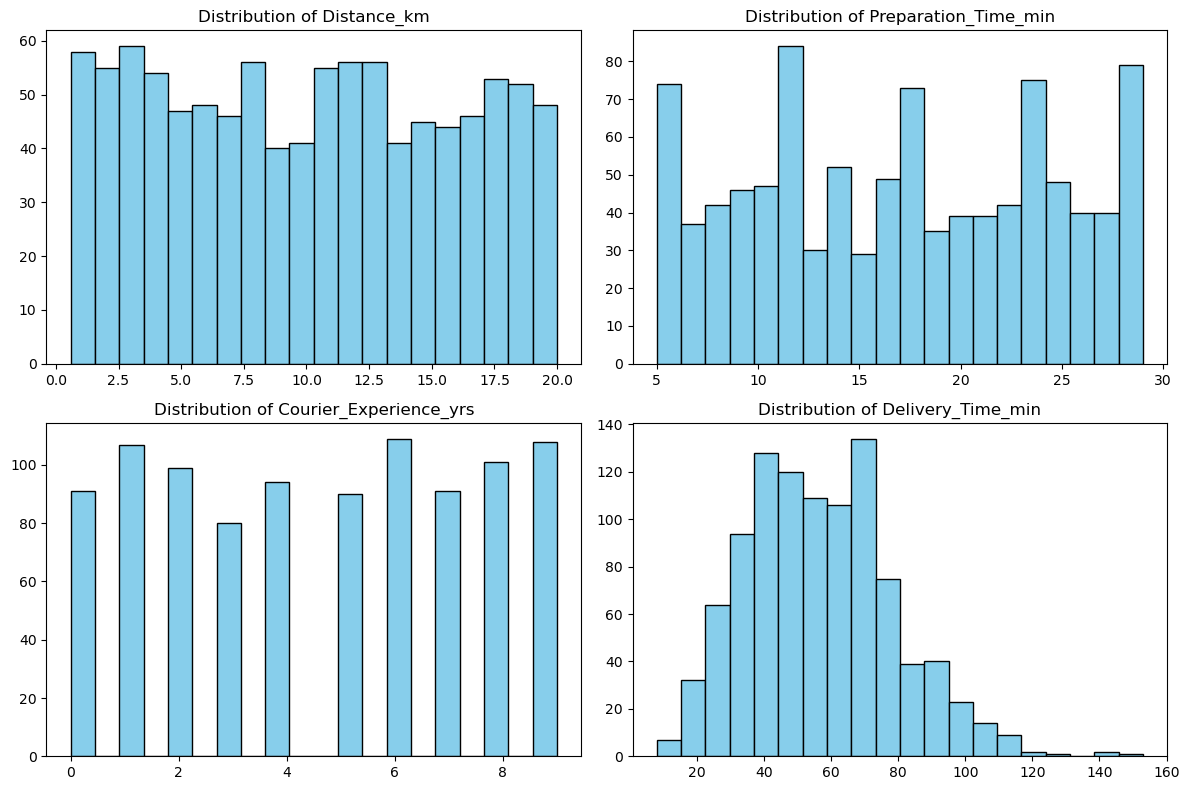

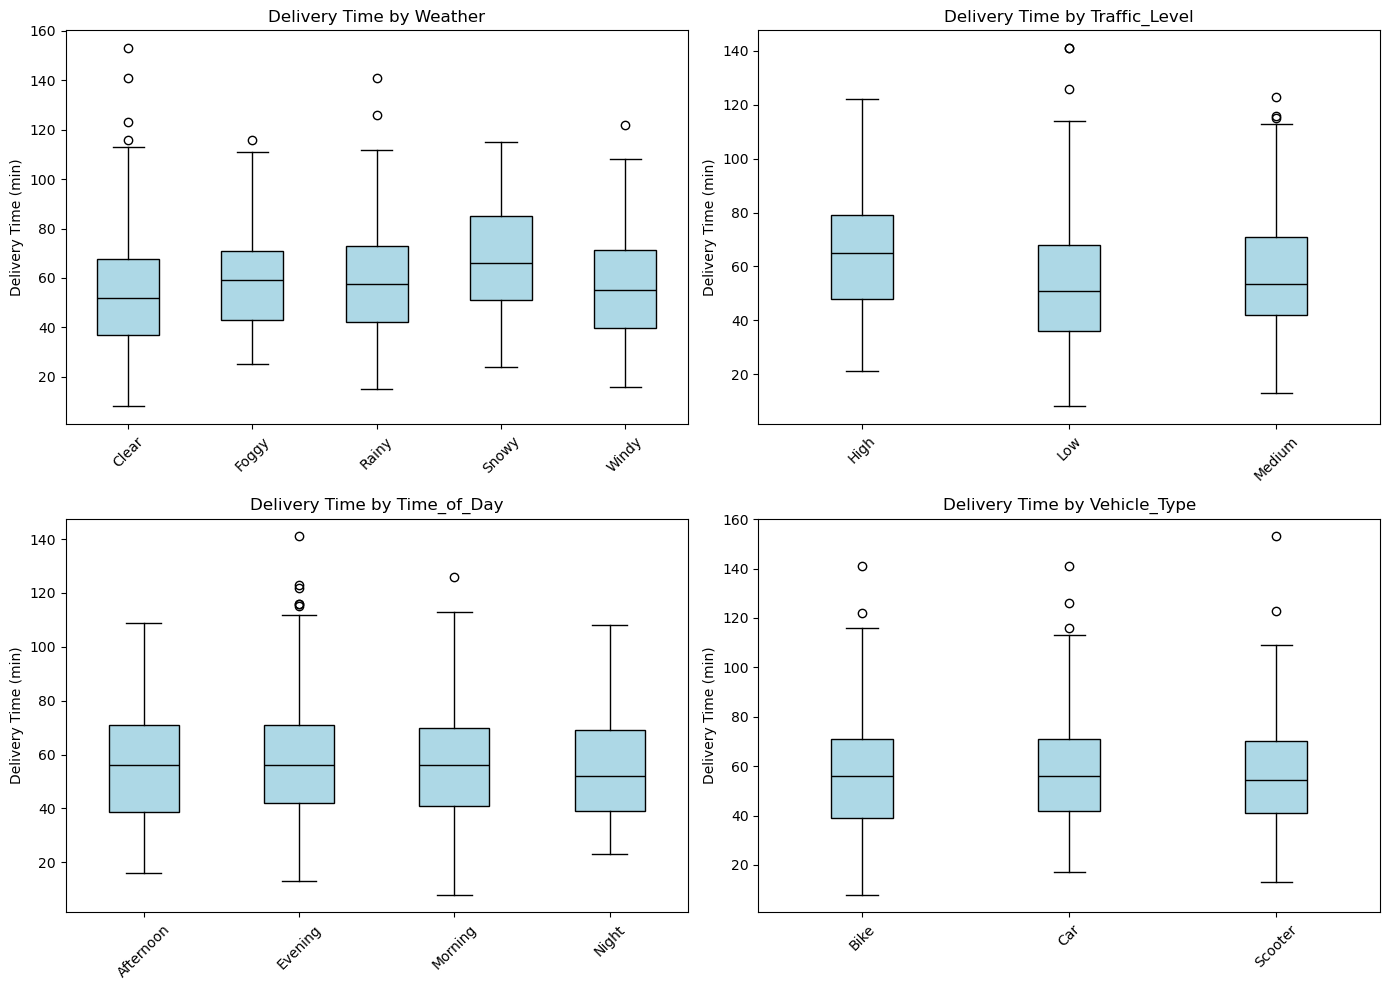

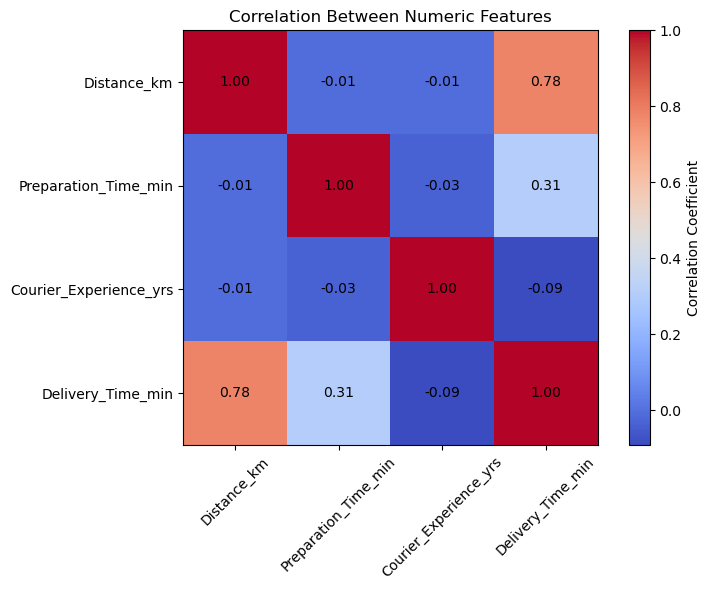


Training samples: 800
Test samples: 200

Linear Regression Performance:
MSE: 78.79
R2 Score: 0.824


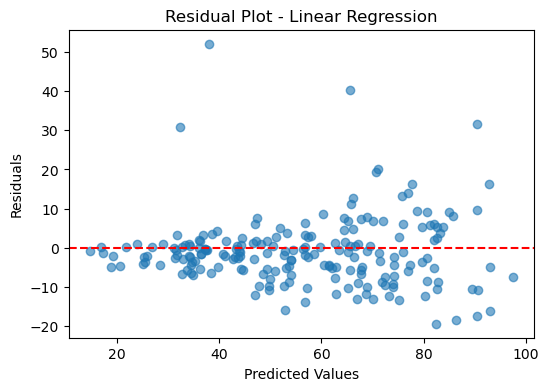

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Random Forest Performance -> MSE: 108.48 R2: 0.758


C:\Users\pavit\AppData\Local\Temp\ipykernel_15656\4210961143.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_rf.head(10), x='Importance', y='Feature', palette="Blues_d")


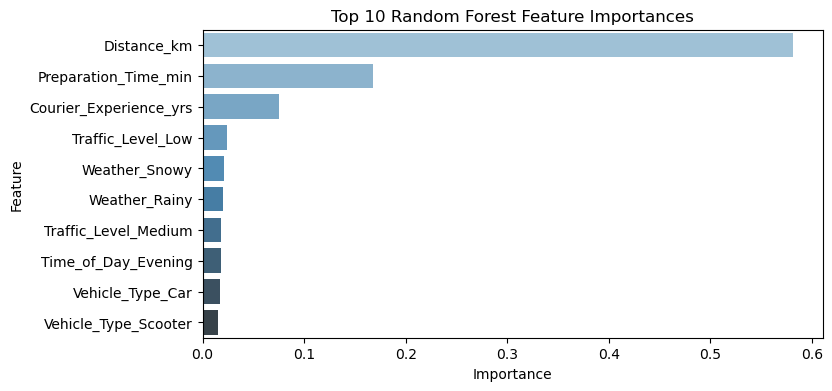

Fitting 3 folds for each of 20 candidates, totalling 60 fits

XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
XGBoost Performance -> MSE: 88.56 R2: 0.802


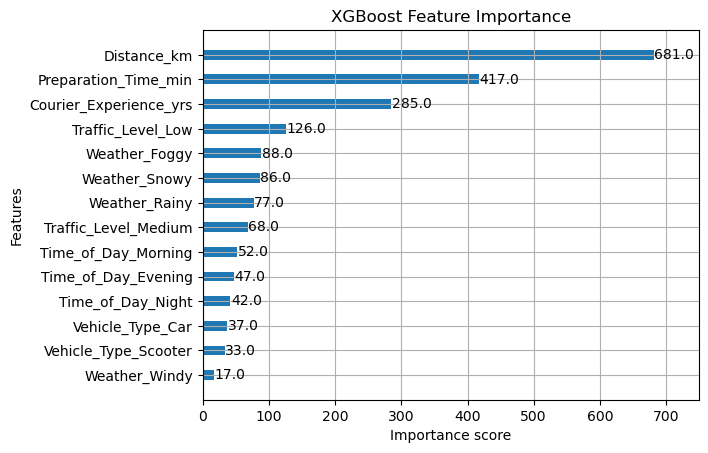


Final Model Comparison:
                   Model         MSE  R2 Score
0      Linear Regression   78.792486  0.824213
1  Random Forest (Tuned)  108.480996  0.757978
2        XGBoost (Tuned)   88.557408  0.802427


C:\Users\pavit\AppData\Local\Temp\ipykernel_15656\4210961143.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x="Model", y="R2 Score", palette="viridis")


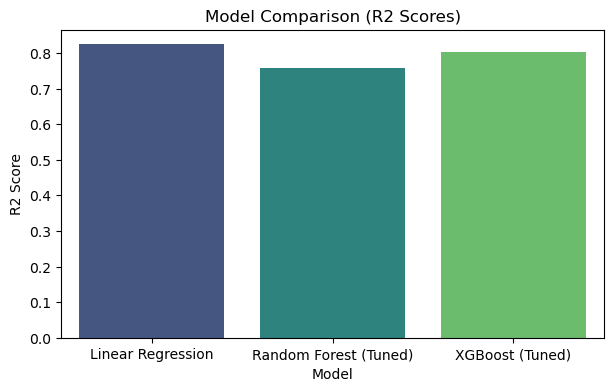

In [1]:
# Food Delivery Time Prediction Project

# Author: Pavithira Seenivasagan
# Goal: Predict food delivery times using different ML models and compare their performance with hyperparameter tuning.

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Load and Inspect Datase
df = pd.read_csv("Food_Delivery_Times.csv")

# Drop irrelevant columns if present
if 'Order_ID' in df.columns:
    df = df.drop(columns=['Order_ID'])

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("\nDataset Information:")
print(df.info())

# 3. Data Cleaning & Preprocessing
# Convert categorical columns to category type
categorical_columns = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

print("\nAfter converting categorical variables:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))

# 4. Exploratory Data Analysis (EDA)
# Distribution of numeric features
numeric_columns = ['Distance_km', 'Preparation_Time_min',
                   'Courier_Experience_yrs', 'Delivery_Time_min']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots of delivery time by categorical variables
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    categories = df[col].cat.categories
    data = [df[df[col] == cat]['Delivery_Time_min'] for cat in categories]
    plt.boxplot(data, labels=categories, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='black'))
    plt.title(f'Delivery Time by {col}')
    plt.ylabel("Delivery Time (min)")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric variables)
corr_matrix = df[numeric_columns].corr().values
labels = numeric_columns

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')
plt.title("Correlation Between Numeric Features")
plt.tight_layout()
plt.show()

# 5. Prepare Data for Modeling
target_column = 'Delivery_Time_min'
X = df.drop(columns=[target_column])
y = df[target_column]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True).fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("\nTraining samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# 6. Baseline Model - Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("\nLinear Regression Performance:")
print("MSE:", round(mse_lin, 2))
print("R2 Score:", round(r2_lin, 3))

# Residual plot
residuals = y_test - y_pred_lin
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lin, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Linear Regression")
plt.show()

# 7. Random Forest with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=20, cv=3, scoring='r2',
    verbose=1, n_jobs=-1, random_state=42
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

y_pred_rf = rf_best.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Best Parameters:", rf_search.best_params_)
print("Random Forest Performance -> MSE:", round(mse_rf, 2), "R2:", round(r2_rf, 3))

# Feature importance plot
feature_importance_rf = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_rf.head(10), x='Importance', y='Feature', palette="Blues_d")
plt.title("Top 10 Random Forest Feature Importances")
plt.show()

# 8. XGBoost with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=xgb_params,
    n_iter=20, cv=3, scoring='r2',
    verbose=1, n_jobs=-1, random_state=42
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

y_pred_xgb = xgb_best.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Best Parameters:", xgb_search.best_params_)
print("XGBoost Performance -> MSE:", round(mse_xgb, 2), "R2:", round(r2_xgb, 3))

# Feature importance plot
xgb.plot_importance(xgb_best, importance_type='weight', height=0.4)
plt.title("XGBoost Feature Importance")
plt.show()

# 9. Model Comparison
summary = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest (Tuned)", "XGBoost (Tuned)"],
    "MSE": [mse_lin, mse_rf, mse_xgb],
    "R2 Score": [r2_lin, r2_rf, r2_xgb]
})

print("\nFinal Model Comparison:")
print(summary)

plt.figure(figsize=(7,4))
sns.barplot(data=summary, x="Model", y="R2 Score", palette="viridis")
plt.title("Model Comparison (R2 Scores)")
plt.ylabel("R2 Score")
plt.show()

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 2. Load and Inspect Datase
df = pd.read_csv("Food_Delivery_Times.csv")

# Drop irrelevant columns if present
if 'Order_ID' in df.columns:
    df = df.drop(columns=['Order_ID'])

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Weather                 970 non-null    object 
 2   Traffic_Level           970 non-null    object 
 3   Time_of_Day             970 non-null    object 
 4   Vehicle_Type            1000 non-null   object 
 5   Preparation_Time_min    1000 non-null   int64  
 6   Courier_Experience_yrs  970 non-null    float64
 7   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB
None


In [3]:
# 3. Data Cleaning & Preprocessing
# Convert categorical columns to category type
categorical_columns = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

print("\nAfter converting categorical variables:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))



After converting categorical variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Distance_km             1000 non-null   float64 
 1   Weather                 970 non-null    category
 2   Traffic_Level           970 non-null    category
 3   Time_of_Day             970 non-null    category
 4   Vehicle_Type            1000 non-null   category
 5   Preparation_Time_min    1000 non-null   int64   
 6   Courier_Experience_yrs  970 non-null    float64 
 7   Delivery_Time_min       1000 non-null   int64   
dtypes: category(4), float64(2), int64(2)
memory usage: 35.9 KB
None

Summary Statistics:
        Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
count   1000.000000     970           970         970         1000   
unique          NaN       5             3           4            3   
top           

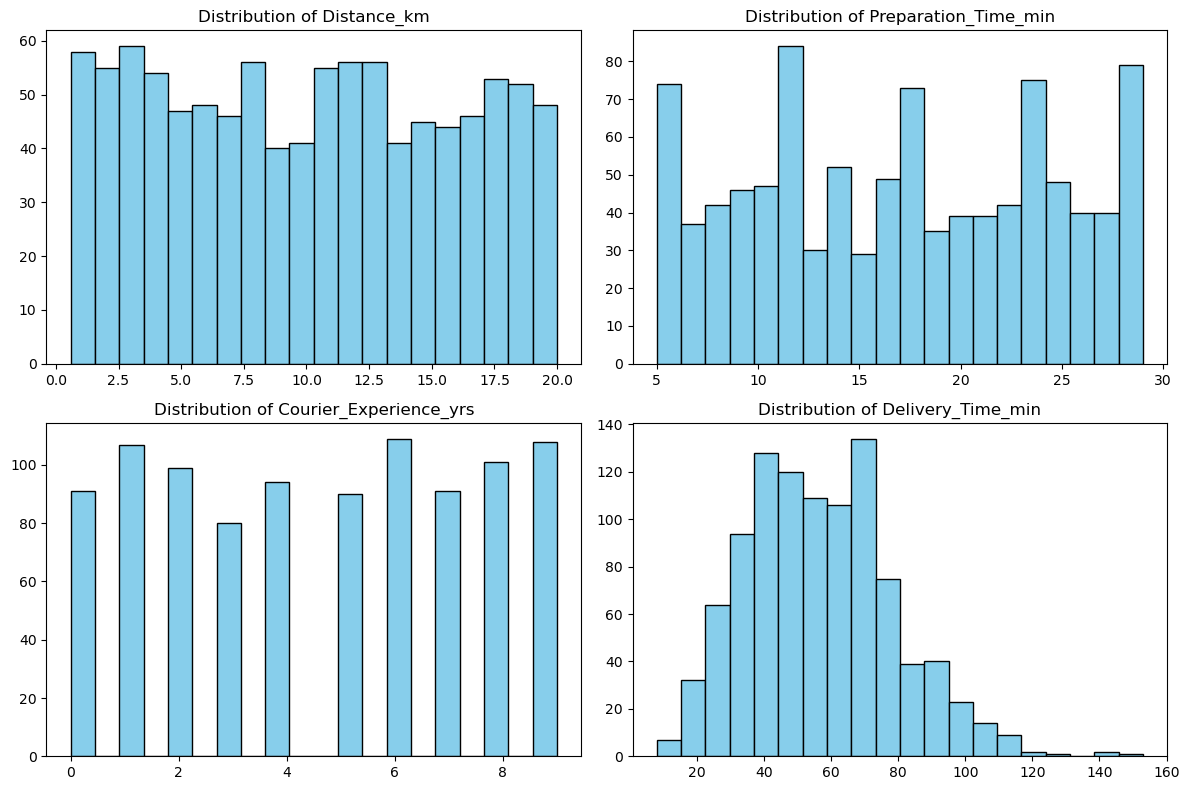

In [4]:
# 4. Exploratory Data Analysis (EDA)
# Distribution of numeric features
numeric_columns = ['Distance_km', 'Preparation_Time_min',
                   'Courier_Experience_yrs', 'Delivery_Time_min']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

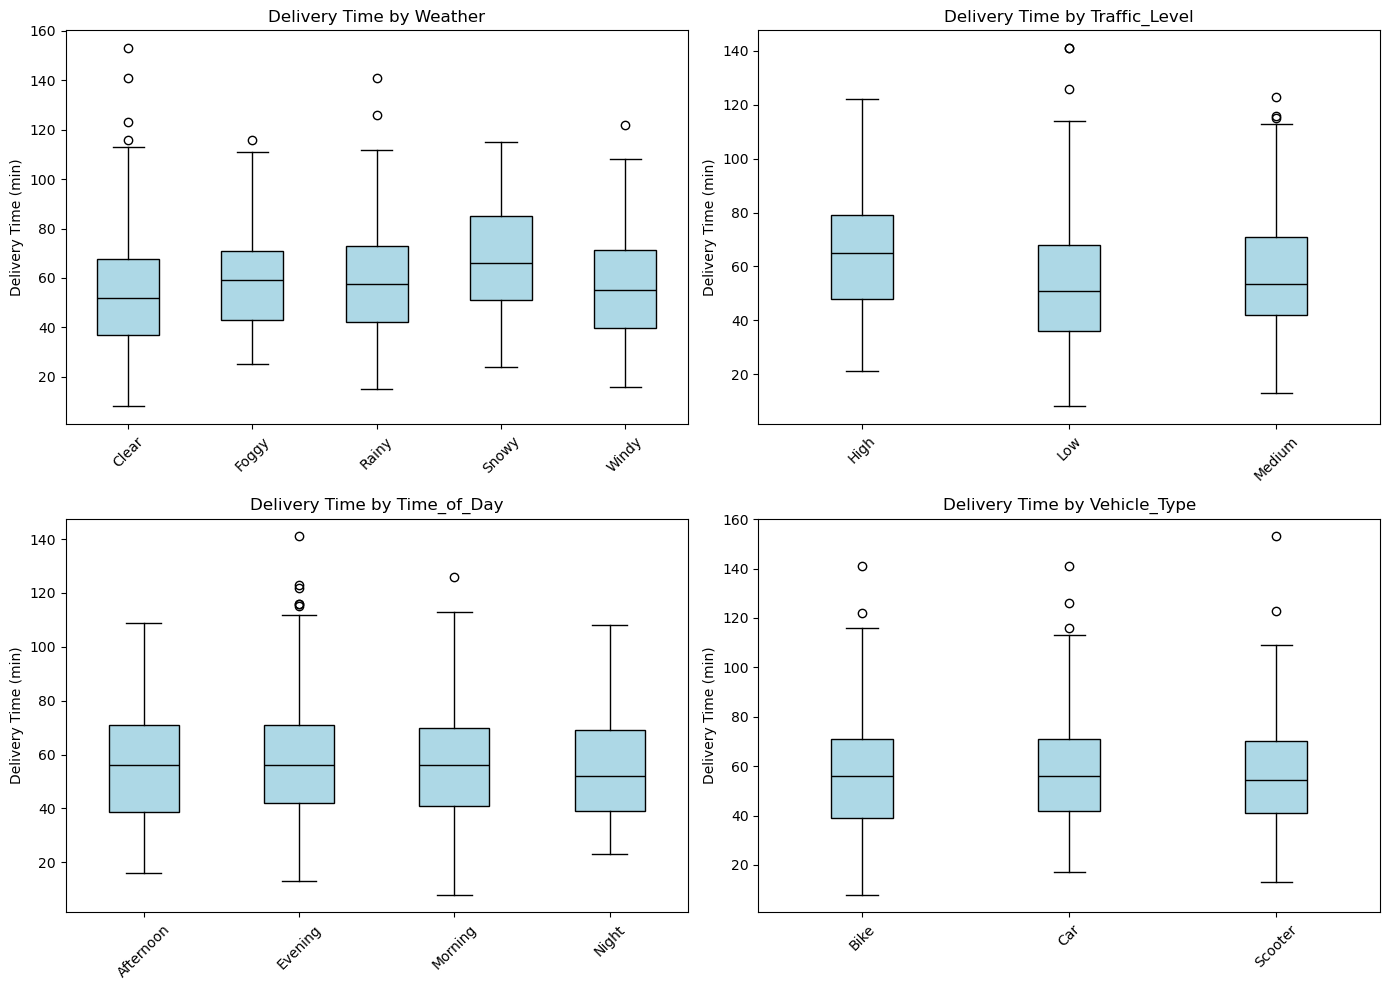

In [5]:
# Boxplots of delivery time by categorical variables
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    categories = df[col].cat.categories
    data = [df[df[col] == cat]['Delivery_Time_min'] for cat in categories]
    plt.boxplot(data, labels=categories, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='black'))
    plt.title(f'Delivery Time by {col}')
    plt.ylabel("Delivery Time (min)")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

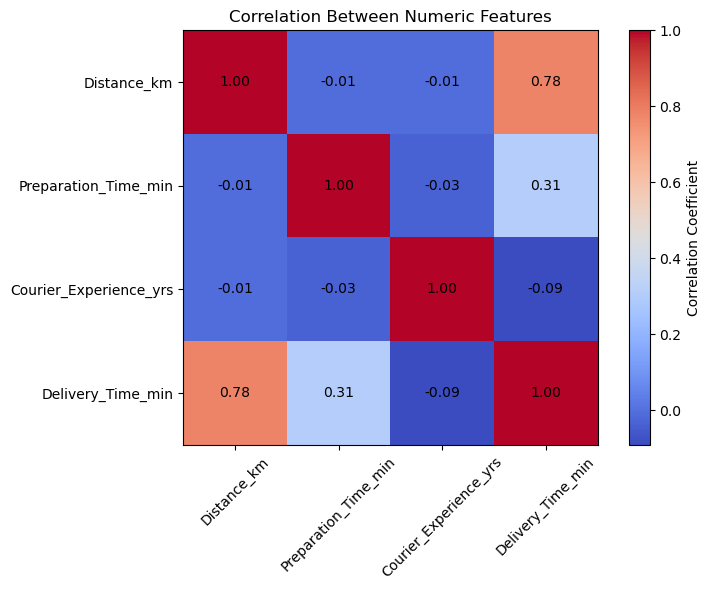

In [10]:
# Correlation heatmap (numeric variables)
corr_matrix = df[numeric_columns].corr().values
labels = numeric_columns

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')
plt.title("Correlation Between Numeric Features")
plt.tight_layout()
plt.show()

In [12]:
# 5. Prepare Data for Modeling
target_column = 'Delivery_Time_min'
X = df.drop(columns=[target_column])
y = df[target_column]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True).fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("\nTraining samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 800
Test samples: 200



Linear Regression Performance:
MSE: 78.79
R2 Score: 0.824


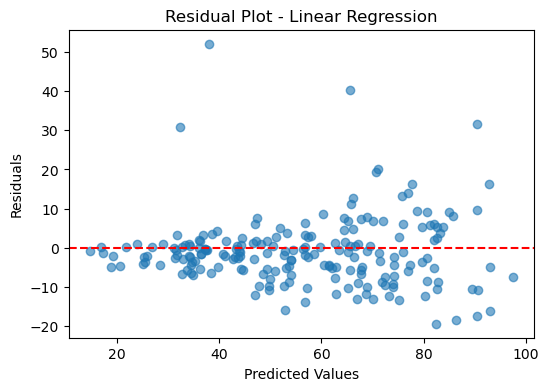

In [15]:
# 6. Baseline Model - Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("\nLinear Regression Performance:")
print("MSE:", round(mse_lin, 2))
print("R2 Score:", round(r2_lin, 3))

# Residual plot
residuals = y_test - y_pred_lin
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lin, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Linear Regression")
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Random Forest Performance -> MSE: 108.48 R2: 0.758


C:\Users\pavit\AppData\Local\Temp\ipykernel_3976\2860304994.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_rf.head(10), x='Importance', y='Feature', palette="Blues_d")


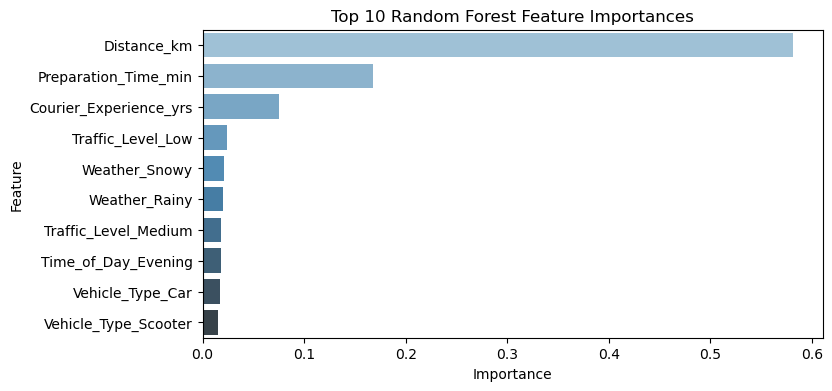

In [17]:
# 7. Random Forest with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=20, cv=3, scoring='r2',
    verbose=1, n_jobs=-1, random_state=42
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

y_pred_rf = rf_best.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Best Parameters:", rf_search.best_params_)
print("Random Forest Performance -> MSE:", round(mse_rf, 2), "R2:", round(r2_rf, 3))

# Feature importance plot
feature_importance_rf = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_rf.head(10), x='Importance', y='Feature', palette="Blues_d")
plt.title("Top 10 Random Forest Feature Importances")
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits

XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
XGBoost Performance -> MSE: 88.56 R2: 0.802


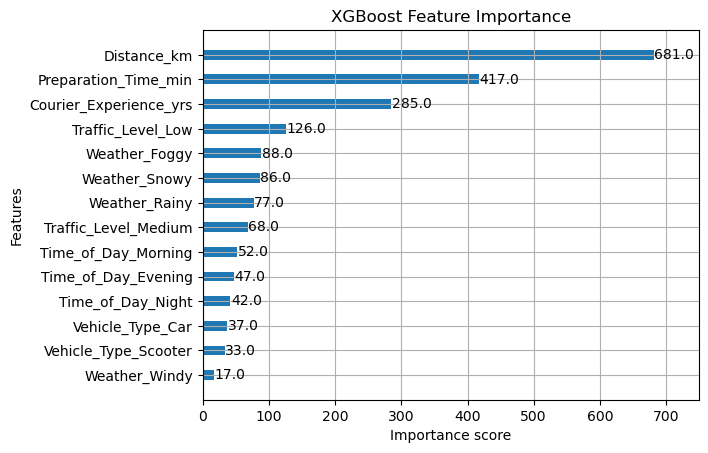

In [18]:
# 8. XGBoost with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=xgb_params,
    n_iter=20, cv=3, scoring='r2',
    verbose=1, n_jobs=-1, random_state=42
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

y_pred_xgb = xgb_best.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Best Parameters:", xgb_search.best_params_)
print("XGBoost Performance -> MSE:", round(mse_xgb, 2), "R2:", round(r2_xgb, 3))

# Feature importance plot
xgb.plot_importance(xgb_best, importance_type='weight', height=0.4)
plt.title("XGBoost Feature Importance")
plt.show()


Final Model Comparison:
                   Model         MSE  R2 Score
0      Linear Regression   78.792486  0.824213
1  Random Forest (Tuned)  108.480996  0.757978
2        XGBoost (Tuned)   88.557408  0.802427


C:\Users\pavit\AppData\Local\Temp\ipykernel_3976\76011811.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x="Model", y="R2 Score", palette="viridis")


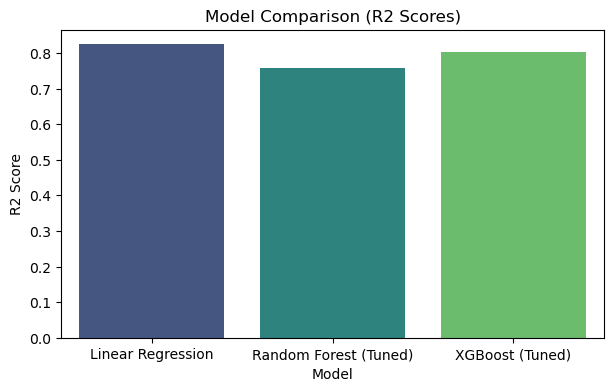

In [19]:
# 9. Model Comparison
summary = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest (Tuned)", "XGBoost (Tuned)"],
    "MSE": [mse_lin, mse_rf, mse_xgb],
    "R2 Score": [r2_lin, r2_rf, r2_xgb]
})

print("\nFinal Model Comparison:")
print(summary)

plt.figure(figsize=(7,4))
sns.barplot(data=summary, x="Model", y="R2 Score", palette="viridis")
plt.title("Model Comparison (R2 Scores)")
plt.ylabel("R2 Score")
plt.show()